The following tutorial is available on the [Wallaroo Github Repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2025.1_tutorials/wallaroo-model-operations-tutorials/deploy/by-use-case/computer-vision-yolov8).

## Computer Vision Yolov8n Deployment in Wallaroo with OpenVINO

The [Yolov8](https://github.com/ultralytics/ultralytics) computer vision model is used for fast recognition of objects in images.  This tutorial demonstrates how to deploy a Yolov8n pre-trained model into a Wallaroo Ops server and perform inferences on it.

For this example, the model's acceleration is set to Intel OpenVINO.

For this tutorial, the helper module `CVDemoUtils` and `WallarooUtils` are used to transform a sample image into a pandas DataFrame.  This DataFrame is then submitted to the Yolov8n model deployed in Wallaroo.

This demonstration follows these steps:

* Upload the Yolo8 model to Wallaroo with the acceleration set to Intel OpenVINO.
* Add the Yolo8 model as a Wallaroo pipeline step.
* Deploy the Wallaroo pipeline and allocate cluster resources to the pipeline.
* Perform sample inferences.
* Undeploy and return the resources .

## Tutorial Notes

To run this tutorial in the **Wallaroo JupyterHub Service**, import the `tensorflow-cpu` library by executing the following command in the terminal shell:

```bash
pip install tensorflow-cpu==2.13.1 --user
```

Then proceed with the tutorial.  This **only** applies to running this tutorial in Wallaroo's JupyterHub service, and does **not** affect model upload and packaging in Wallaroo.

## References

* [Wallaroo Workspaces](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/):  Workspaces are environments were users upload models, create pipelines and other artifacts.  The workspace should be considered the fundamental area where work is done.  Workspaces are shared with other users to give them access to the same models, pipelines, etc.
* [Wallaroo Model Upload and Registration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/): ML Models are uploaded to Wallaroo through the SDK or the MLOps API to a **workspace**.  ML models include default runtimes (ONNX, Python Step, and TensorFlow) that are run directly through the Wallaroo engine, and containerized runtimes (Hugging Face, PyTorch, etc) that are run through in a container through the Wallaroo engine.
* [Wallaroo Pipelines](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/): Pipelines are used to deploy models for inferencing.  Each model is a **pipeline step** in a pipelines, where the inputs of the previous step are fed into the next.  Pipeline steps can be ML models, Python scripts, or Custom Model (these contain necessary models and artifacts for running a model).

## Steps

### Load Libraries

The first step is loading the required libraries including the [Wallaroo Python module](https://pypi.org/project/wallaroo/).

In [1]:
# Import Wallaroo Python SDK
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework
from CVDemoUtils import CVDemo
from WallarooUtils import Util
cvDemo = CVDemo()
util = Util()

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)


### Connect to the Wallaroo Instance through the User Interface

The next step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [2]:
# Login through local Wallaroo instance

wl = wallaroo.Client()

### Create a New Workspace

We'll use the SDK below to create our workspace , assign as our **current workspace**, then display all of the workspaces we have at the moment.  We'll also set up variables for our models and pipelines down the road, so we have one spot to change names to whatever fits your organization's standards best.

To allow this tutorial to be run by multiple users in the same Wallaroo instance, a random 4 character prefix will be added to the workspace, pipeline, and model.  Feel free to set `suffix=''` if this is not required.

In [3]:
model_name = 'yolov8n-openvino'
model_filename = 'models/yolov8n.onnx'
pipeline_name = 'yolo8demonstration-openvino'
workspace_name = f'yolo8-demonstration-openvino'


### Upload the Model

When a model is uploaded to a Wallaroo cluster, it is optimized and packaged to make it ready to run as part of a pipeline. In many times, the Wallaroo Server can natively run a model without any Python overhead. In other cases, such as a Python script, a custom Python environment will be automatically generated. This is comparable to the process of "containerizing" a model by adding a small HTTP server and other wrapping around it.

Our pretrained model is in ONNX format, which is specified in the `framework` parameter.  For this model, the tensor fields are set to `images` to match the input parameters, and the batch configuration is set to `single` - only one record will be submitted at a time.

The acceleration value is set to `wallaroo.engine_config.Acceleration.OpenVINO`.  This value is inherited later at the deployment configuration and pipeline publishing.

In [4]:
# Upload Retrained Yolo8 Model 
import wallaroo.engine_config


yolov8_model = (wl.upload_model(model_name, 
                               model_filename, 
                               framework=Framework.ONNX,
                               accel=wallaroo.engine_config.Acceleration.OpenVINO)
                               .configure(tensor_fields=['images'],
                                          batch_config="single"
                                          )
                )

### Pipeline Deployment Configuration

For our pipeline we set the deployment configuration to only use 1 cpu and 1 GiB of RAM.  Note that the AI accelerator is not specified - this value is inherited from the model's acceleration settings.

In [5]:
deployment_config = wallaroo.DeploymentConfigBuilder() \
                    .replica_count(1) \
                    .cpus(1) \
                    .memory("1Gi") \
                    .build()

### Build and Deploy the Pipeline

Now we build our pipeline and set our Yolo8 model as a pipeline step, then deploy the pipeline using the deployment configuration above.

In [6]:
pipeline = wl.build_pipeline(pipeline_name) \
            .add_model_step(yolov8_model)        

In [7]:
pipeline.deploy(deployment_config=deployment_config, wait_for_status=False)

Deployment initiated for yolo8demonstration-openvino. Please check pipeline status.


name,yolo8demonstration-openvino
created,2025-07-14 20:43:10.883365+00:00
last_updated,2025-07-14 20:49:07.064061+00:00
deployed,True
workspace_id,108
workspace_name,john.hummel@wallaroo.ai - Default Workspace
arch,x86
accel,openvino
tags,
versions,"a98f8d67-b45f-4fef-92eb-92076ab0d5cc, 6f2d6a26-f895-4fbf-b4ee-2a7e57f56dac, 009245ac-8364-4316-b8c7-dd48df8b1a94, 9f855537-4df1-4491-82aa-6e1d4a9143b3"
steps,yolov8n-openvino


In [8]:
import time
time.sleep(15)

while pipeline.status()['status'] != 'Running':
    time.sleep(15)
    print("Waiting for deployment.")
    pipeline.status()['status']
pipeline.status()['status']


'Running'

### Convert Image to DataFrame

The sample image `dogbike.png` was converted to a DataFrame using the `cvDemo` helper modules.  The converted DataFrame is stored as `./data/dogbike.df.json` to save time.

The code sample below demonstrates how to use this module to convert the sample image to a DataFrame.

```python
# convert the image to a tensor

width, height = 640, 640
tensor1, resizedImage1 = cvDemo.loadImageAndResize('dogbike.png', width, height)
tensor1.flatten()

# add the tensor to a DataFrame and save the DataFrame in pandas record format
df = util.convert_data(tensor1,'images')
df.to_json("data.json", orient = 'records')
```

In [9]:
# convert the image to a tensor

width, height = 640, 640
tensor1, resizedImage1 = cvDemo.loadImageAndResize('./data/dogbike.png', width, height)

tensor1.flatten()

# add the tensor to a DataFrame and save the DataFrame in pandas record format
df = util.convert_data(tensor1,'images')
df.to_json("data.json", orient = 'records')

### Inference Request

We submit the DataFrame to the pipeline using `wallaroo.pipeline.infer_from_file`, and store the results in the variable `inf1`.

In [10]:
inf1 = pipeline.infer_from_file('data.json')

### Display Bounding Boxes

Using our helper method `cvDemo` we'll identify the objects detected in the photo and their bounding boxes.  Only objects with a confidence threshold of 50% or more are shown.

In [11]:
inf1.loc[:, ['out.output0']]

,out.output0
0,"[17.097874, 16.459345, 17.259743, 19.960596, 43.60022, 59.986965, 62.826073, 68.247925, 77.43261, 80.82158, 89.44183, 96.168915, 99.2242, 112.584015, 126.75801, 131.97072, 137.16452, 141.93823, 146.29596, 152.00876, 155.94035, 165.20975, 175.2725, 184.0531, 193.66891, 201.5119, 215.04976, 223.80426, 227.24472, 234.19638, 244.97429, 248.57806, 252.42526, 264.95792, 278.48566, 285.758, 293.1897, 300.48227, 305.47742, 314.46085, 319.89404, 324.83658, 335.99533, 345.11157, 350.31964, 352.411, 365.44946, 381.3001, 391.5232, 399.29163, 405.78503, 411.338, 415.93204, 421.68677, 431.67108, 439.9069, 447.71545, 459.38525, 474.1318, 479.3264, 484.49887, 493.5153, 501.2993, 507.79666, 514.26044, 523.1472, 531.3479, 542.5094, 555.6191, 557.7229, 564.6408, 571.55255, 572.8372, 587.95703, 604.2997, 609.452, 616.31714, 623.5797, 624.13153, 634.47266, 16.970057, 16.788725, 17.441803, 17.900644, 36.18802, 57.277977, 61.664352, 62.55689, 63.43486, 79.5062, 83.843994, 95.98375, 106.16601, 115.36844, 123.09251, 124.5821, 128.65866, 139.16113, 142.02315, 143.69856, ...]"


  Score: 86.47% | Class: Dog | Bounding Box: [108, 250, 149, 356]
  Score: 81.13% | Class: Bicycle | Bounding Box: [97, 149, 375, 323]
  Score: 63.17% | Class: Car | Bounding Box: [390, 85, 186, 108]


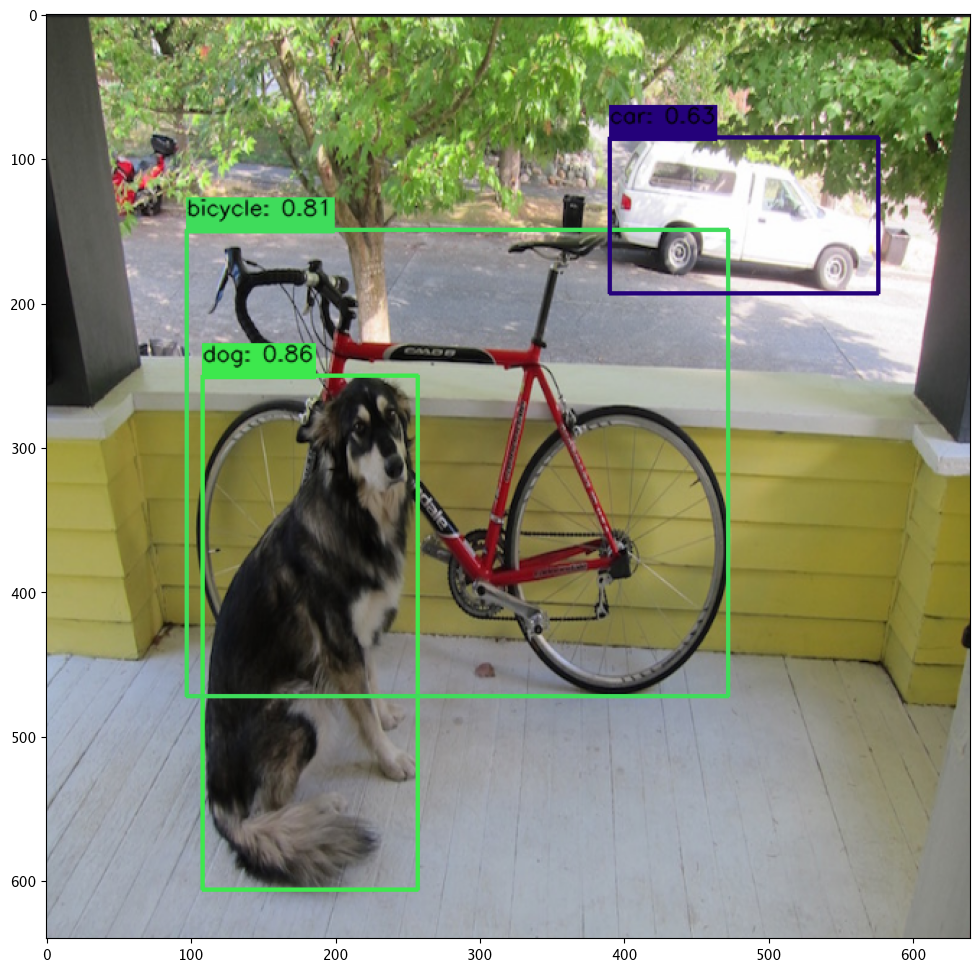

array([[[ 34,  34,  34],
        [ 35,  35,  35],
        [ 33,  33,  33],
        ...,
        [ 33,  33,  33],
        [ 33,  33,  33],
        [ 35,  35,  35]],

       [[ 33,  33,  33],
        [ 34,  34,  34],
        [ 34,  34,  34],
        ...,
        [ 34,  34,  34],
        [ 33,  33,  33],
        [ 34,  34,  34]],

       [[ 53,  54,  48],
        [ 54,  55,  49],
        [ 54,  55,  49],
        ...,
        [153, 178, 111],
        [151, 183, 108],
        [159, 176,  99]],

       ...,

       [[159, 167, 178],
        [159, 165, 177],
        [158, 163, 175],
        ...,
        [126, 127, 121],
        [127, 125, 120],
        [128, 120, 117]],

       [[160, 168, 179],
        [156, 162, 174],
        [152, 157, 169],
        ...,
        [126, 127, 121],
        [129, 127, 122],
        [127, 118, 116]],

       [[155, 163, 174],
        [155, 162, 174],
        [152, 158, 170],
        ...,
        [127, 127, 121],
        [130, 126, 122],
        [128, 119, 116]]

In [12]:
confidence_thres = 0.50
iou_thres = 0.25

cvDemo.drawYolo8Boxes(inf1, resizedImage1, width, height, confidence_thres, iou_thres, draw=True)

### Inference Through Pipeline API

Another method of performing an inference using the pipeline's deployment url.

Performing an inference through an API requires the following:

* The authentication token to authorize the connection to the pipeline.
* The pipeline's inference URL.
* Inference data to sent to the pipeline - in JSON, DataFrame records format, or Apache Arrow.

Full details are available through the [Wallaroo API Connection Guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-api-guide/wallaroo-mlops-connection-guide/) on how retrieve an authorization token and perform inferences through the pipeline's API.

For this demonstration we'll submit the pandas record, request a pandas record as the return, and set the authorization header.  The results will be stored in the file `curl_response.df`.

In [13]:
deploy_url = pipeline._deployment._url()

headers = wl.auth.auth_header()

headers['Content-Type']='application/json; format=pandas-records'
headers['Accept']='application/json; format=pandas-records'

In [14]:
!curl -X POST {deploy_url} \
    -H "Authorization:{headers['Authorization']}" \
    -H "Content-Type:application/json; format=pandas-records" \
    -H "Accept:application/json; format=pandas-records" \
    --data @./data/dogbike.df.json > curl_response.df

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38.0M  100 22.9M  100 15.0M  4923k  3240k  0:00:04  0:00:04 --:--:-- 8640k100 15.0M      0  7199k  0:00:02  0:00:02 --:--:-- 7201k


### Publish Pipeline

### Publish Pipeline for ARM

Publishing the pipeline uses the pipeline `wallaroo.pipeline.Pipeline.publish()` command.  This requires that the Wallaroo Ops instance have [Edge Registry Services](https://docs.wallaroo.ai/wallaroo-platform-operations/wallaroo-platform-operations-configure/wallaroo-edge-deployment/#enable-wallaroo-edge-deployment-registry) enabled.

When publishing, we specify the pipeline deployment configuration through the `wallaroo.DeploymentConfigBuilder`.  For our example, we do **not** specify the architecture; the architecture and acceleration is inherited from the model.  In this case, OpenVINO.

The following publishes the pipeline to the OCI registry and displays the container details.  For more information, see [Wallaroo SDK Essentials Guide: Pipeline Edge Publication](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/).

#### OpenVINO Deployment

Deploying ML Models with **Intel OpenVINO hardware with Intel GPUs** in edge and multi-cloud environments via `docker run` require additional parameters.

For more details, see:

* Running in privileged Docker deployments:[Runtime privilege and Linux capabilities](https://docs.docker.com/engine/reference/run/#runtime-privilege-and-linux-capabilities)
* Running in unprivileged Docker deployments: [Additional groups](https://docs.docker.com/engine/reference/run/#additional-groups)

For ML models deployed on OpenVino hardware with Intel GPUs, `docker run` **must** include the following options:

```bash
--rm -it --device /dev/dri --group-add=$(stat -c "%g" /dev/dri/render* ) --ulimit nofile=262144:262144 --cap-add=sys_nice
```

For example, the following `docker run` templates demonstrates deploying a Wallaroo published model on OpenVINO hardware with Intel GPUs:

```bash
docker run -v $PERSISTENT_VOLUME_DIR:/persist \
    --rm -it --device /dev/dri \
    --group-add=$(stat -c "%g" /dev/dri/render* ) \
    --ulimit nofile=262144:262144 --cap-add=sys_nice \
    -p $EDGE_PORT:8080 \
    -e OCI_USERNAME=$OCI_USERNAME \
    -e OCI_PASSWORD=$OCI_PASSWORD \
    -e PIPELINE_URL={PIPELINE_URL}:{PIPELINE_VERSION} \
    {Wallaroo_Engine_URL}:{WALLAROO_ENGINE_VERSION}
```

Note that the AI accelerator is not specified - this value is inherited from the model's acceleration settings.

In [15]:
pub = pipeline.publish()
display(pub)

Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is publishing... Published.


ID,103
Pipeline Name,yolo8demonstration-openvino
Pipeline Version,9cbd84ff-65fa-4fd2-8b63-456789f7ba37
Status,Published
Workspace Id,108
Workspace Name,john.hummel@wallaroo.ai - Default Workspace
Edges,
Engine URL,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini:v2025.1.0-6245
Pipeline URL,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/pipelines/yolo8demonstration-openvino:9cbd84ff-65fa-4fd2-8b63-456789f7ba37
Helm Chart URL,oci://us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/charts/yolo8demonstration-openvino
Helm Chart Reference,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/charts@sha256:e3665f72504763432efd5b15b98cfd088e205c3c83587b2b8936f52f8fb4bc27


### Undeploy Pipeline

With the tutorial complete, we undeploy the pipeline and return the resources back to the cluster.

In [17]:
pipeline.undeploy()

name,yolo8demonstration-openvino
created,2025-07-14 20:43:10.883365+00:00
last_updated,2025-07-14 20:52:19.343339+00:00
deployed,False
workspace_id,108
workspace_name,john.hummel@wallaroo.ai - Default Workspace
arch,x86
accel,openvino
tags,
versions,"9cbd84ff-65fa-4fd2-8b63-456789f7ba37, a98f8d67-b45f-4fef-92eb-92076ab0d5cc, 6f2d6a26-f895-4fbf-b4ee-2a7e57f56dac, 009245ac-8364-4316-b8c7-dd48df8b1a94, 9f855537-4df1-4491-82aa-6e1d4a9143b3"
steps,yolov8n-openvino
